# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
from collections import Counter
import pickle
import re
import string
from string import punctuation
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sys
!{sys.executable} -m pip install progressbar
import progressbar 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

nltk.download(['stopwords', 'punkt', 'averaged_perceptron_tagger', 'wordnet'])

%matplotlib inline

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# convert article_id in df to str type
df['article_id'] = df['article_id'].apply(str)
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
user_interaction = df.groupby('email').count()['article_id'].reset_index()
user_interaction.columns = ['email', 'count']

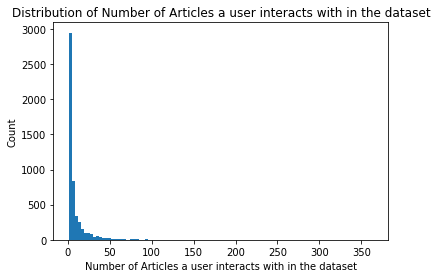

In [6]:
plt.hist(user_interaction['count'], bins=100);
plt.xlabel('Number of Articles a user interacts with in the dataset');
plt.ylabel('Count');
plt.title('Distribution of Number of Articles a user interacts with in the dataset');

In [7]:
# descriptive stats
user_interaction['count'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: count, dtype: float64

In [8]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset='article_id') == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles = (df.groupby('article_id')['title'].count()>0).sum() # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [12]:
print('There are {} unique articles that have at least one interaction.'.format(unique_articles))
print('There are {} unique articles on the IBM platform.'.format(total_articles))
print('There are {} unique users.'.format(unique_users))
print('There are {} user-article interactions.'.format(user_article_interactions))

There are 714 unique articles that have at least one interaction.
There are 1051 unique articles on the IBM platform.
There are 5148 unique users.
There are 45993 user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
max_views = df.groupby('article_id')['title'].count().max() # The most viewed article in the dataset was viewed how many times?
most_viewed_article_id = (df.groupby('article_id')['title'].count()).idxmax() # The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id,max_views

('1429.0', 937)

In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': df.shape[0],
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = np.array(df.groupby('title')['user_id'].count().sort_values(ascending=False).iloc[:n].index)
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = np.array(df.groupby('article_id')['user_id'].count().sort_values(ascending=False).iloc[:n].index)
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
['1429.0' '1330.0' '1431.0' '1427.0' '1364.0' '1314.0' '1293.0' '1170.0'
 '1162.0' '1304.0']


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id']).nunique()['title'].unstack().fillna(0)
    return user_item 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    users_series = np.array(np.transpose(user_item).columns)
    # compute similarity of each user to the provided user
    similarity = np.dot(user_item.loc[user_id], np.transpose(user_item))
    # sort by similarity
    sort_idx = np.argsort(similarity)[::-1]
    # create list of just the ids
    sort_id = users_series[sort_idx]
    # remove the own user's id
    user_idx = np.where(sort_id == user_id)
    most_similar_users = np.delete(sort_id, user_idx)
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    ''' 
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(set(df[df.article_id.isin(article_ids)]['title']))
    return np.array(article_names) # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = np.array(user_item.columns[user_item.loc[user_id] >0])
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations ids for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = set()
    
    articles_seen, _ = get_user_articles(user_id)
    similar_user_ids = find_similar_users(user_id)
    i=0
    for similar_user_id in similar_user_ids:
        article_ids, _ = get_user_articles(similar_user_id)
        #print(article_names, articles_seen)
        rec = np.setdiff1d(article_ids, articles_seen)
        #print(set(rec))
        recs.update(rec)

        if len(recs) >= m:
            break

    recs = list(recs)
    return recs[:m] # return your recommendations for this user_id    

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['deploy your python model as a restful api',
       'improving real-time object detection with yolo',
       'intents & examples for ibm watson conversation',
       'analyze open data sets with spark & pixiedust',
       'automating web analytics through python',
       'working with db2 warehouse on cloud in data science experience',
       'pixieapp for outlier detection',
       'model bike sharing data with spss',
       'airbnb data for analytics: vancouver listings',
       'use decision optimization to schedule league games'], 
      dtype='<U62')

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbor_ids = find_similar_users(user_id)
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_ids})
    
    neighbors_df['similarity'] = neighbors_df['neighbor_id'].apply(lambda x: np.dot(user_item.loc[user_id], user_item.loc[x]))
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: len(get_user_articles(x)[0]))
    
    ranked_neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    return ranked_neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = list()
    articles_seen_user, _ = get_user_articles(user_id)
    ranked_neighbors = get_top_sorted_users(user_id)

    for neighbor_id in ranked_neighbors['neighbor_id']:
        articles_seen_neighbor, _ = get_user_articles(neighbor_id)
        rec = np.setdiff1d(articles_seen_neighbor, articles_seen_user)

        for article in rec:
            if article not in recs:
                recs.append(article)
            if len(recs) >= m:
                break
                
        if len(recs) >= m:
            break
    rec_names = get_article_names(recs)
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1014.0', '1059.0', '109.0', '111.0', '1157.0', '1162.0', '1164.0', '1172.0', '1186.0', '12.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 3: machine learning'
 'tidy up your jupyter notebooks with scripts' 'tensorflow quick tips'
 'airbnb data for analytics: washington d.c. listings'
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object'
 'analyze energy consumption in buildings'
 'analyze open data sets with pandas dataframes'
 'airbnb data for analytics: amsterdam calendar'
 'timeseries data analysis of iot events by using jupyter notebook'
 'connect to db2 warehouse on cloud and db2 using scala']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results
user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(n=10) # Your recommendations here

In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### In this part, I'll use the 'doc_body' feature in the df_content dataframe and apply NLP to extract information to discover the similarity between different documents.

In [33]:
# check null values
df_content[df_content.doc_body.isnull()==True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873


### use 'doc_full_name' as the document body where there is nan in the 'doc_body' column

In [34]:
df_corpus = df_content[['doc_body', 'article_id', 'doc_full_name']].copy()

In [35]:
null_body_index = df_corpus[df_content.doc_body.isnull()==True].index.values.tolist()
null_description = df_content.loc[null_body_index, 'doc_full_name'].values.tolist()

for i, idx in enumerate(null_body_index):
    df_corpus.loc[idx, 'doc_body'] = null_description[i]


## Helper function

In [36]:
url_regex = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+')
emoji_regex = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)

def get_wordnet_tag(postag): 
    '''
    Convert pos_tag to wordnet tag
    INPUTS:
    postag: nltk part of speech tag
    OUTPUTS:
    wordnet part of speech tag
    '''
    if postag.startswith('N'):
        return wordnet.NOUN
    if postag.startswith('J'):
        return wordnet.ADJ
    if postag.startswith('V'):
        return wordnet.VERB
    if postag.startswith('R'):
        return wordnet.ADV
    
def clean_doc(document, remove_stopwords=True):
    '''
    Clean document by
    1. set to lowercase and remove \r\n
    2. replace url with placeholder
    3. replace emoji with placeholder
    4. remove punctuation and number
    5. tokenize document
    6. remove stop words
    7. pos-tag word
    8. word lemmatization
    Return the cleaned list of words
    
    INPUT:
    document(str): a string of article content
    remove_stopwords(bool): remove stop words or not
    OUTPUT:
    tokens(list): list of words 
    '''

    # set to lowercase and remove \r\n
    document = ' '.join(x.lower().strip('\r\n') for x in document.split())
    # replace url with placeholder
    document = url_regex.sub('urlplaceholder', document) 
    # replace emoji with placeholder
    document = emoji_regex.sub('emojiplaceholder', document)
    # remove punctuation and number
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # tokenize doc
    tokens = word_tokenize(document)
    # remove stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stopwords.words('english')]
    # word lemmatization
    clean_tokens = []
    lemm = WordNetLemmatizer()
    for t, postag in pos_tag(tokens):
        wordnet_tag = get_wordnet_tag(postag)
        if wordnet_tag is not None:
            clean_t = lemm.lemmatize(t, pos=wordnet_tag)
        else:
            clean_t = lemm.lemmatize(t)
        
        clean_tokens.append(clean_t)
    return clean_tokens

In [37]:
corpus = df_corpus['doc_body'].values.tolist()

In [38]:
clean_corpus = []
pbar = progressbar.ProgressBar(maxval=len(corpus), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
pbar.start()

for i, doc in enumerate(corpus):
    pbar.update(i+1)
    clean_corpus.append(clean_doc(doc))

In [39]:
# tag corpus
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(clean_corpus)]

In [40]:
epochs = 15
vector_size = 20
min_count = 0
window = 5

# initialize doc2vec model
model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs, dm=1, window=window)
# build vocabulary
model.build_vocab(tagged_corpus)

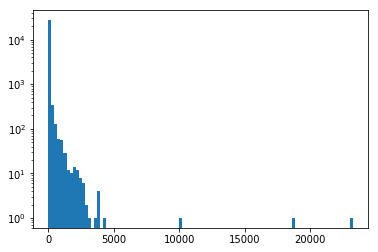

In [41]:
# examine words frequency
word_count = []

for w in model.wv.vocab:
    word_count.append(model.wv.vocab[w].count)

plt.hist(word_count, bins=100, log=True);

In [42]:
# examine outlier words
highest_freq_words = []
for w in model.wv.vocab:
    count = model.wv.vocab[w].count
    if count > 5000:
        highest_freq_words.append(w)
print(highest_freq_words)

['urlplaceholder', 'data', 'use']


In [43]:
# create trim rule to eliminate the high frequency words
def rule(word, count, min_count):
    '''
    Eliminate the top 3 highest frequency word and 
    the word appears less than min_count times from 
    the corpus
    
    INPUTS:
    word(str)
    count(int): number of occurrence of the word
    min_count(int): minimum occurrence of the word to keep
    OUPUTS:
    gensim rule to keep the word or not
    '''
    if word in highest_freq_words:
        return gensim.utils.RULE_DISCARD
    else:
        return gensim.utils.RULE_DEFAULT

In [44]:
# evaluate model
# How many times the model finds the inferred vector of the document is most similar to be the document itself.
def evaluate_model(model, corpus, topn=3):
    '''
    Evaluate the doc2vec model by finding the most 
    similar document of the inferred vector of the 
    document.
    
    INPUTS:
    model: doc2vec model
    corpus: TaggedDocuments
    topn: (int) the top n most similar documents
    OUPUT:
    sim_to_self:(counter) number of times the document 
    appears as the nth most similar documents to the 
    inferred vector
    '''
    sim_to_self = Counter()

    for i in range(len(corpus)):
        inferred_vector = model.infer_vector(corpus[i].words)
        top_sims = model.docvecs.most_similar([inferred_vector], topn=topn)
        
        for j in range(topn):
            if top_sims[j][0] == i:
                sim_to_self[j] += 1
    
    return sim_to_self

In [47]:
# try train the model for different number of epochs, chose the best one
max_epochs = 30
min_count = 2
window = 2
self_sim_perct = []
print('Begin training ...')
print('Percentage of the most similar document of the inferred vector of a document is found to be itself')

for e in range(1, max_epochs+1):
    model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=e, dm=1, alpha=0.025, window=2)
    model.build_vocab(tagged_corpus, trim_rule=rule)
    model.train(tagged_corpus, total_examples=model.corpus_count, epochs=e)
    model_metric = evaluate_model(model, tagged_corpus, 3)
    val = model_metric[0]/len(tagged_corpus)*100
    self_sim_perct.append(val)
    
    print('Trained model for {} epochs: {:.3f}%'.format(e, val))

Begin training ...
Percentage of the most similar document of the inferred vector of a document is found to be itself
Trained model for 1 epochs: 2.759%
Trained model for 2 epochs: 24.833%
Trained model for 3 epochs: 52.807%
Trained model for 4 epochs: 75.167%
Trained model for 5 epochs: 82.969%
Trained model for 6 epochs: 88.202%
Trained model for 7 epochs: 91.151%
Trained model for 8 epochs: 92.008%
Trained model for 9 epochs: 92.103%
Trained model for 10 epochs: 93.911%
Trained model for 11 epochs: 93.054%
Trained model for 12 epochs: 93.340%
Trained model for 13 epochs: 94.006%
Trained model for 14 epochs: 93.911%
Trained model for 15 epochs: 94.386%
Trained model for 16 epochs: 92.959%
Trained model for 17 epochs: 93.720%
Trained model for 18 epochs: 94.386%
Trained model for 19 epochs: 94.006%
Trained model for 20 epochs: 94.101%
Trained model for 21 epochs: 93.340%
Trained model for 22 epochs: 94.006%
Trained model for 23 epochs: 93.720%
Trained model for 24 epochs: 94.101%
Trai

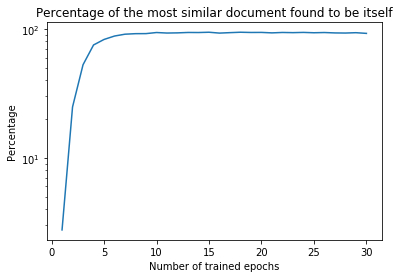

In [48]:
plt.plot([e+1 for e in range(max_epochs)], self_sim_perct);
plt.xlabel('Number of trained epochs');
plt.ylabel('Percentage');
plt.title('Percentage of the most similar document found to be itself');
plt.yscale('log')

In [49]:
# choose the optimized epochs 
# train the model
opt_ephochs = 10

model = Doc2Vec(vector_size=vector_size, min_count=2, epochs=opt_ephochs, dm=1, alpha=0.025, window=2)
model.build_vocab(tagged_corpus, trim_rule=rule)
model.train(tagged_corpus, total_examples=model.corpus_count, epochs=opt_ephochs)
print('Doc2Vec trained!')

Doc2Vec trained!


In [50]:
# save model
model.save('d2v.model')
print('Model saved!')

Model saved!


In [51]:
# load model
model = Doc2Vec.load('d2v.model')
print('Model loaded!')

Model loaded!


In [52]:
unique_articles = len(tagged_corpus)

def create_content_similarity_matrix(model, uniq_articles=unique_articles):
    '''
    Create a matrix containting similarity scores between every article-article pairs
    INPUTS:
    model: trained doc2vec model
    uniq_articles(int): number of unique articles in the tagged corpus
    OUPUTS:
    article_sim_mat(numpy array): matrix with similarity scores between every 2 articles
    '''
    article_sim_mat = np.zeros((uniq_articles, uniq_articles))
    for i in range(uniq_articles):
        for j in range(uniq_articles):
            article_sim_mat[i,j] = model.docvecs.similarity(i, j)
    return article_sim_mat

article_sim_mat = create_content_similarity_matrix(model)

In [53]:
def get_similar_articles_d2v(article_id, model=model, df_corpus=df_corpus, df=df, article_sim_mat=article_sim_mat):
    '''
    Find the most similar articles to the given article_id
    If the article_id exist in the training data, find the most similar articles except itself
    Otherwise, use the article title and its inferred vector to find the most similar articles
    INPUTS:
    article_id(str)
    model: doc2vec model
    df_corpus(pandas dataframe): dataframe with doc_body
    df(pandas dataframe): dataframe with user-article interaction
    article_sim_mat(numpy matrix): matrix with similarity scores between every 2 articles
    OUTPUT:
    ranked_article_ids(numpy array): list of ranked article ids
    ranked_article_names(numpy array): list of ranked article names
    '''
    article_ids_series = np.array(df_corpus.article_id.values)
    ranked_article_names = []
    if int(float(article_id)) in df_corpus.article_id.values.tolist():
        article_id = int(float(article_id))
        #locate article index in the df_corpus
        article_idx = df_corpus[df_corpus.article_id==article_id].index.values[0]
        # similarities
        sims = article_sim_mat[article_idx]
        # rank articles from most dissimilar to most similar
        ranked_idx = np.argsort(sims)
        # get ranked article_ids from index
        ranked_article_ids = article_ids_series[ranked_idx]
        # delete article itself
        ranked_article_ids = np.delete(ranked_article_ids, np.where(ranked_article_ids==article_id))
        ranked_article_ids = ranked_article_ids[::-1]
        
    else:
        # if article id not in df_content,but in df, use doc title to find similar doc
        doc = df[df.article_id==article_id]['title'].unique()[0]
        # clean doc and tokenize
        clean_toks = clean_doc(doc)
        
        inferred_vector = model.infer_vector(clean_toks)
    
        most_sim_idx = model.docvecs.most_similar([inferred_vector], topn=df_corpus.shape[0])
        ranked_idx = [k for k, _ in most_sim_idx]
        ranked_article_ids = article_ids_series[ranked_idx]
        
    ranked_article_names = []
    for i in ranked_article_ids:
        ranked_article_names.append(df_corpus[df_corpus.article_id==i]['doc_full_name'].values[0])
        
    return ranked_article_ids, ranked_article_names

In [54]:
def make_content_recs(user_id, df=df, df_corpus=df_corpus, num_recs=10, article_sim_mat=article_sim_mat, model=model):
    '''
    Recommends the most popular articles and their most similar articles
    INPUTS:
    user_id(str)
    df(pandas dataframe): dataframe with user-article interaction
    df_corpus(pandas dataframe): dataframe with doc_body
    num_recs(int): number of recommendations to make
    article_sim_mat(numpy matrix): matrix with similarity scores between every 2 articles
    model: trained doc2vec model 
    OUTPUTS:
    recs_id(numpy array): recommended article ids
    recs_name(numpy array): recommended article names
    '''
    # convert user_id to int
    user_id = int(float(user_id))
    recs_id = []
    recs_name = []
    article_ids_series = np.array(df_corpus.article_id.values)
    
    # if user exists in current database, 
    if user_id in df.user_id.values.tolist():
        # get the articles the user interacted with
        articles_seen_ids, _ = get_user_articles(user_id)
        
        # if num_recs is larger than number of articles seen by user, 
        # for each article seen, recommend the top k most similar articles
        if num_recs >= len(articles_seen_ids):
            k = num_recs//len(articles_seen_ids)
            last_k = num_recs-k*(len(articles_seen_ids)-1)
           
            for i, articles_seen_id in enumerate(articles_seen_ids):
                #locate article index in the df_corpus
                #article_idx = df_corpus[df_corpus.article_id==articles_seen_id].index.values[0]
                rec_id, rec_name = get_similar_articles_d2v(articles_seen_id)

                if i < (len(articles_seen_ids)-1):
                    cntr = 0
                    for j, name in enumerate(rec_name):
                        if (rec_id[j] not in articles_seen_ids) and (rec_id[j] not in recs_id):
                            recs_id.append(rec_id[j])
                            recs_name.append(name)
                            cntr += 1
                        if cntr == k:
                            break
                    
                else:
                    cntr = 0
                    for j, name in enumerate(rec_name):
                        if (rec_id[j] not in articles_seen_ids) and (rec_id[j] not in recs_id):
                            recs_id.append(rec_id[j])
                            recs_name.append(name)
                            cntr += 1
                        if cntr == last_k:
                            break
        # if num_recs is smaller than number of articles seen by user,
        # randomly shuffle articles_seen_ids, 
        # recommend top 1 most similar articles untill num_recs reached
        else:
            np.random.shuffle(articles_seen_ids)
            cntr = 0
            for i, articles_seen_id in enumerate(articles_seen_ids):
                article_idx = df_corpus[df_corpus.article_id==articles_seen_id].index.values[0]
                rec_id, rec_name = get_similar_articles_d2v(articles_seen_id)
                for j, name in enumerate(rec_name):
                    if (rec_id[j] not in articles_seen_ids) and (rec_id[j] not in recs_id):
                        recs_id.append(rec_id[j])
                        recs_name.append(name)
                        cntr += 1
                        break
                if cntr == num_recs:
                    break
    
    # if user is new to the platform, 
    else:
        # get the topn most popular articles 
        recs_id = get_top_article_ids(num_recs, df=df)
        recs_name = get_top_articles(num_recs, df=df)
    return  recs_id, recs_name

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Explanation of the content based recommendation system.** <br><br>
The content based recommendation system is based on a doc2vec model. First, a doc2vec model is trained on the article bodys and finds vector representations for each articles, which makes it possible to compute the similarity between articles. The model is evaluated by the percentage of the most similar document found to be itself, and an optimized number of epochs is chosen based on this evaluation.<br>
The content based recommendation system:
- If the give user exists in the training data, find the most similar articles to the articles user has interacted with.
    - If the articles seen by user exists in the training data, find the most similar articles to this article body.
    - If the articles seen by user does not exist in the training data, find the most similar articles to this article title.
- If the number of recommendations is lager than the number of articles seen by user, recommend the top k most similar articles for each articles seen by user.
- If the number of recommendations is smaller than the number of articles seen by user, randomly shuffle the articles seen list and recommend the top 1 most similar articles for each article seen by user, until number of recommendations satisfied. This random shuffling helps to avoid making the same recommendations to users every time.
- If user does not exist in the training data, recommend the most popular articles, which has the most user interactions.
<br><br>
The novel part of this content based recommendation system is that it's trying to make recommendations for every articles the user has interacted with, which makes it able to recommend everything that user has shown interests in and increase the system diversity.
<br>
Future improvement can be made in the case of making recommendations to a new user. 


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [55]:
# make recommendations for a brand new user
num_recs = 10
new_user = '0.0'
print('Top {} recommendations for new user {}'.format(num_recs, new_user))
recs_names = make_content_recs(new_user)[1]
print(recs_names)

# make a recommendations for a user who only has interacted with article id '1427.0'
num_recs = 10
user_id = '1427.0'
print('Top {} recommendations for new user {}'.format(num_recs, user_id))
recs_names = make_content_recs(user_id)[1]
print(recs_names)

Top 10 recommendations for new user 0.0
['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']
Top 10 recommendations for new user 1427.0
['Interactive Web Apps with shiny Cheat Sheet', 'A comparison of logistic regression and naive Bayes ', 'Foundational Methodology for Data Science', 'Load data from the desktop into dashDB', 'The Definitive Guide', 'Analyze traffic data from the city of San Francisco', 'Visualizing weather data as a PixieApp – IBM Watson Data Lab – Medium', 'Brunel interactive visualizations in Jupyter notebooks', 'Run Shin

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [56]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [57]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [58]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(np.array(user_item_matrix)) # use the built in to get the three matrices

**Provide your response here.** <br>
In the lesson, we have exact ratings from user-item interaction, these ratings range from 0 to 10. Then we have missing values, if the user haven't watched the movie or haven't rated it. However, in this case, if the user has not seen the article, we use 0 to indicate this senario, 1 otherwise. So, in this case, we have no missing values, then we can perform SVD on the dataset.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

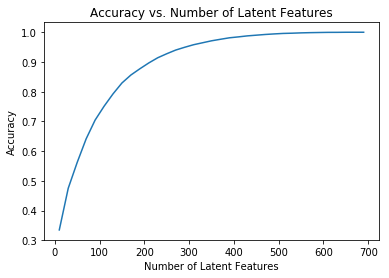

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
train_idx = set(df_train.user_id.unique())
train_arts = set(df_train.article_id.unique())
common_user = len(set(test_idx).intersection(train_idx))
common_arts = len(set(test_arts).intersection(train_arts))
print('How many users can we make predictions for in the test set? {}'.format(common_user))
print('How many users in the test set are we not able to make predictions for because of the cold start problem? {}'.format(len(set(test_idx))-common_user))
print('How many articles can we make predictions for in the test set? {}'.format(common_arts))
print('How many articles in the test set are we not able to make predictions for because of the cold start problem? {}'.format(len(set(test_arts))-common_arts))

How many users can we make predictions for in the test set? 20
How many users in the test set are we not able to make predictions for because of the cold start problem? 662
How many articles can we make predictions for in the test set? 574
How many articles in the test set are we not able to make predictions for because of the cold start problem? 0


In [62]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [63]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train))# fit svd similar to above then use the cells below

In [64]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
common_user_ids = set(test_idx).intersection(train_idx)
common_article_ids = set(test_arts).intersection(train_arts)

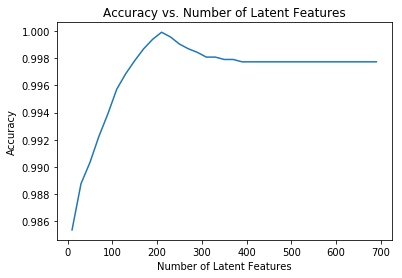

In [65]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

train_article_series = np.array(user_item_train.columns)
train_user_series = np.array(user_item_train.index)
test_article_series = np.array(user_item_test.columns)
test_user_series = np.array(user_item_test.index)

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product on test set
    cum_errs_test = 0
    for i in common_user_ids:
        row = np.where(train_user_series == i)[0][0]
        
        for j in common_article_ids:
            col = np.where(train_article_series == j)[0][0]
            
            user_item_est_test = np.around(np.dot(np.dot(u_new[row], s_new), vt_new[:, col]))
            row_test = np.where(test_user_series == i)[0][0]
            col_test = np.where(test_article_series == j)[0][0]
            diffs_test = user_item_est_test - np.array(user_item_test)[row_test, col_test]
            cum_errs_test += diffs_test
       
    err_test = np.sum(np.sum(np.abs(cum_errs_test)))
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/len(common_article_ids)/len(common_user_ids));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**<br>

From the plot above, 210 of latent features will yield the best accuracy(very close to 100%) on the test dataset. The SVD with 210 latent features is able to predict the user-article interaction with very high accuracy. However, it's unable to recommend articles to users/articles that do not exist in the training dataset. So, a most-popular-articles recommendation system and a content based recommendation system are provided to solve this cold start problem. <br><br>
In order to determine if the recommendations from these systems are making improvments, an A/B test with cookie-based diversion can be set up. Randomly pick two groups of users, make sure they are identical using invariant metrics like number of cookies generated for each group. The controlled group will be displayed recommendations with the old recommendation system. The experiment group will be displayed recommendations with the new recommendation system. The portion of interactions user has with the recommendations out of all recommendations user get from the system will be tracked and used as the evaluation metric. The experiment size, run time, type error rate needs to be determined. If the evaluation metric is significantly higher in the experiment group than in the control group, it mean the new recommendation systems are making improvement.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0